<a href="https://colab.research.google.com/github/MKolaksazov/Machine-Learning/blob/master/Social%20Media%20Sentiment%20Analysis/SentimentAnalysisIMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from zipfile import ZipFile
file_name = "aclImdb.zip"
with ZipFile(file_name, "r") as zip:
    zip.extractall()
    print("Done")

Done


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.externals import joblib

In [0]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import os
import glob
import re

BASE_DATA_FOLDER = "aclImdb"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

ROWS = 12500+12500
COLS = 2

reviews_train = np.ndarray(shape=(ROWS, COLS), dtype=object)
reviews_train = list(reviews_train)

for i, file_path in enumerate(glob.glob(os.path.join(TRAin_DATA_FOLDER, '*', "*.txt"))):
    if re.split(r"\\", str(file_path))[2] != 'unsup':
        for line in open(str(file_path), 'r', encoding="utf8"):
            reviews_train[i][0] = str(line.strip())
            reviews_train[i][1] = str(re.split('_|\\.', str(file_path))[1])           

In [0]:
print(reviews_train[20000])

["This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the media. The

In [0]:
BASE_DATA_FOLDER = "aclImdb"
Test_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "test")

ROWS = 12500+12500
COLS = 2

reviews_test = np.ndarray(shape=(ROWS, COLS), dtype=object)
reviews_test = list(reviews_test)

for i, file_path in enumerate(glob.glob(os.path.join(Test_DATA_FOLDER, '*', "*.txt"))):
    #if re.split(r"\\", str(file_path))[2] != 'unsup':
        for line in open(str(file_path), 'r', encoding="utf8"):
            reviews_test[i][0] = str(line.strip())
            reviews_test[i][1] = str(re.split('_|\\.', str(file_path))[1])  

In [0]:
print(reviews_test[20000])

["'In the Line of Fire' is one of those Hollywood films that shows up on tv quite a bit, but although I've seen it a few times, I usually end up sitting through the whole thing again. Why? - It's GOOD! Clint Eastwood is great as usual, and the character he plays is interesting and more fleshed out than usual. The character, Secret Service agent Frank Horrigan, is haunted by the fact that he was on the detail that failed to protect President Kennedy in Dallas, and now he's forced to match wits with a professional assassin that is openly declaring that he will kill the president. However, the film doesn't make him a depressed, brooding, and obsessed character. He's charming and personable, and is realistic as a guy that has experienced a lot in life and is comfortable in his own skin. He's even quite convincing when he flirts with the pretty younger agent played by Rene Russo. The killer, played by John Malkovich at his best, is cerebral, deliberate, and enjoys playing high stakes games 

In [0]:
replace_no_space = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\\)")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

In [0]:
def preprocess_reviews(reviews):
    reviews = [replace_no_space.sub("", str(line).lower()) for line in reviews]
    reviews = [replace_with_space.sub(" ", line) for line in reviews]
    return reviews

In [0]:
reviews_train_clean = preprocess_reviews(np.asarray(reviews_train)[:,0])
reviews_test_clean = preprocess_reviews(np.asarray(reviews_test)[:,0])

In [0]:
print(reviews_train_clean[20000])

this documentary now available free on videogooglecom is a fantastic demonstration of the power of ordinary people to overcome injustice everyone must see this chavez was elected in a landslide vote in 1998 his platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor he banned foreign drift net fishing in venezuelan waters he sent 10000 cuban doctors to the slums to treat the sick for free he wiped out illiteracy and set up new free universities  but it was his 30% tax on oil company profits that got him in trouble with the bush administration in 2002 while irish film makers kim bartley and donnacha obriain were interviewing chavez inside the presidential palace about his social programs a cia backed coup was launched with the cameras rolling chavez was captured and flown out of the country it was announced on national tv that he had resigned but the poor of venezuela didnt believe the media they went to the palace in their millions and demanded that ch

In [0]:
print(reviews_test_clean[20000])

in the line of fire is one of those hollywood films that shows up on tv quite a bit but although ive seen it a few times i usually end up sitting through the whole thing again why   its good clint eastwood is great as usual and the character he plays is interesting and more fleshed out than usual the character secret service agent frank horrigan is haunted by the fact that he was on the detail that failed to protect president kennedy in dallas and now hes forced to match wits with a professional assassin that is openly declaring that he will kill the president however the film doesnt make him a depressed brooding and obsessed character hes charming and personable and is realistic as a guy that has experienced a lot in life and is comfortable in his own skin hes even quite convincing when he flirts with the pretty younger agent played by rene russo the killer played by john malkovich at his best is cerebral deliberate and enjoys playing high stakes games of life and death he even goes b

In [0]:
reviews_train_label = np.asarray(reviews_train)[:,1]
reviews_test_label = np.asarray(reviews_test)[:,1]

In [0]:
english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(' '.join([word for word in review.split() if word not in english_stop_words]))
    return removed_stop_words

In [0]:
reviews_train_ready = remove_stop_words(reviews_train_clean)
reviews_test_ready = remove_stop_words(reviews_test_clean)

In [0]:
print(reviews_train_ready[20000])

documentary available free videogooglecom fantastic demonstration power ordinary people overcome injustice everyone must see chavez elected landslide vote 1998 platform divert fantastic oil wealth 20% middle class 80% poor banned foreign drift net fishing venezuelan waters sent 10000 cuban doctors slums treat sick free wiped illiteracy set new free universities 30% tax oil company profits got trouble bush administration 2002 irish film makers kim bartley donnacha obriain interviewing chavez inside presidential palace social programs cia backed coup launched cameras rolling chavez captured flown country announced national tv resigned poor venezuela didnt believe media went palace millions demanded chavez returned face overwhelming numbers military turned coup leaders plotters fled us chavez rescued military helicopter returned jubilation


In [0]:
print(reviews_test_ready[20000])

line fire one hollywood films shows tv quite bit although ive seen times usually end sitting whole thing good clint eastwood great usual character plays interesting fleshed usual character secret service agent frank horrigan haunted fact detail failed protect president kennedy dallas hes forced match wits professional assassin openly declaring kill president however film doesnt make depressed brooding obsessed character hes charming personable realistic guy experienced lot life comfortable skin hes even quite convincing flirts pretty younger agent played rene russo killer played john malkovich best cerebral deliberate enjoys playing high stakes games life death even goes name another presidential assassin john booth film consistently enjoyable delivers goods suspense action romance drama proper amounts fun film really helped great actors


In [0]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_ready)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
reviews_features = tfidf_vectorizer.transform(reviews_train_ready)
x_test = tfidf_vectorizer.transform(reviews_test_ready)

In [0]:
labels = [0 if i < 12500 else 1 for i in range(25000)]
x_train, x_val, y_train, y_val = train_test_split(reviews_features, labels, train_size=0.8, random_state=42)

x_train.shape
x_train

<20000x92694 sparse matrix of type '<class 'numpy.float64'>'
	with 2027185 stored elements in Compressed Sparse Row format>

In [0]:
x_train[0]

<1x92694 sparse matrix of type '<class 'numpy.float64'>'
	with 164 stored elements in Compressed Sparse Row format>

In [0]:
k_fold = StratifiedKFold(n_splits = 5)
k_fold.split(x_train, y_train)

<generator object _BaseKFold.split at 0x0000000015DFE408>

In [0]:
def model_logistic_regression_tuned(x, y):
    grid_search = GridSearchCV(LogisticRegression(), tuned_params)
    model_logistic_regression = grid_search.fit(x, y)
    return model_logistic_regression.best_estimator_

In [0]:
tuned_params = [{"C": [0.05, 0.1, 0.3, 0.5, 1]}]
model_logistic_regression_tuned(x_train, y_train)

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
tuned_params = [{"C": [1, 2, 3, 4, 5]}]
model_logistic_regression_tuned(x_train, y_train)

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
tuned_params = [{"C": [3.5, 4, 4.5], "max_iter": [5, 10, 15]}]
model_logistic_regression_tuned(x_train, y_train)

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=4.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5, multi_class='warn', n_jobs=None,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
model_logistic_regression = LogisticRegression(C = 4, max_iter = 10)
model_logistic_regression.fit(x_train, y_train)

LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
accuracy_train = accuracy_score(y_train, model_logistic_regression.predict(x_train))
accuracy_validation = accuracy_score(y_val, model_logistic_regression.predict(x_val))

In [0]:
print("Training score:", round(accuracy_train, 2))
print("Validation score:", round(accuracy_validation, 2))

Training score: 0.98
Validation score: 0.89


In [0]:
final_accuracy = accuracy_score(labels, model_logistic_regression.predict(x_test))
print("Testing score:", round(final_accuracy, 2))

Testing score: 0.88


In [0]:
def receiver_perating_characteristic(model, x, y, accuracy):
    plt.figure(figsize = (10, 7))
    y_pred_proba = model.predict_proba(x)[::, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc = roc_auc_score(y, y_pred_proba)
    plt.plot(fpr, tpr, label = "ROC curve, auc = " + str(accuracy))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = 4)
    plt.show()

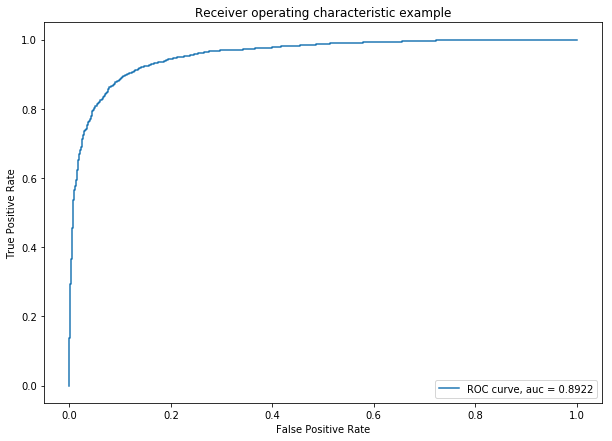

In [0]:
receiver_perating_characteristic(model_logistic_regression, x_val,
y_val, accuracy_validation)

In [0]:
joblib.dump(model_logistic_regression, 'Movie_Reviews.pkl')

['Movie_Reviews.pkl']

In [0]:
reiews_alita = []
for line in open("alita.txt", 'r'):
    reiews_alita.append(line.strip())

reviews_alita_clean = preprocess_reviews(reiews_alita)
reviews_alita_ready = remove_stop_words(reviews_alita_clean)
reviews_alita_ready

['п»їin 2563 three hundred years war fall mysterious scientist dr dyson ido christoph waltz finds part female cyborg junkyard brings laboratory finds human brain amnestic intact gives name deceased daughter alita rosa salazar cyborg alita meets street dr idoвґs ex wife chiren jennifer connelly also scientist works powerful zapan ed skrein befriends young hugo keean johnson brings cyborgвґs parts dr ido learns dream moving floating city zalem hugo teaches alita play motorball learns champion motorball tournament moves zalem soon alita discovers dr ido hunter warrior finding cyborg body crashed spaceship decides become also hunter warrior dr ido refuses replace body alita secret cyborg body found alita alita battle angel sci fi adventure great screenplay cast special effects japanese anime amnestic cyborg finds engaging sci fi fan dr ido sort cyborg dr frankenstein direction robert rodriguez entertaining usualthe conclusion indicates sequel vote eight title brazil alita anjo de combate a

In [0]:
reiews_alita_ready = tfidf_vectorizer.transform(reviews_alita_ready)

reiews_alita_ready.shape

(8, 92694)

In [0]:
clf2 = joblib.load('Movie_Reviews.pkl')
# Predict data set using loaded model
predict = clf2.predict(reiews_alita_ready)
# 8,10,8,7,1,2,2,3
predict

array([1, 1, 1, 0, 0, 0, 0, 0])